In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiffusionLayer(nn.Module):
    """
    A custom diffusion layer inspired by Gaussian smoothing.
    This layer enhances feature representation by diffusing pixel values.
    """
    def __init__(self, kernel_size=3, sigma=1.0):
        super(DiffusionLayer, self).__init__()
        # Gaussian kernel
        x = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
        kernel = torch.exp(-x**2 / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        self.kernel = kernel.view(1, 1, kernel_size, 1) * kernel.view(1, 1, 1, kernel_size)
    
    def forward(self, x):
        # Convolution with the Gaussian kernel
        channels = x.shape[1]
        kernel = self.kernel.repeat(channels, 1, 1, 1).to(x.device)
        return F.conv2d(x, kernel, padding='same', groups=channels)

class ForgeryDetectionModel(nn.Module):
    def __init__(self):
        super(ForgeryDetectionModel, self).__init__()
        
        self.diffusion1 = DiffusionLayer(kernel_size=5, sigma=1.5)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.diffusion2 = DiffusionLayer(kernel_size=3, sigma=1.0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Apply first diffusion layer
        x = self.diffusion1(x)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Apply second diffusion layer
        x = self.diffusion2(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten for fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


In [9]:
import os
from PIL import Image
import numpy as np
import torch

# Directory paths
authentic_path = "C:/Users/91931/Downloads/casia_dataset/casia_dataset/Authentic"
forged_path = "C:/Users/91931/Downloads/casia_dataset/casia_dataset/Spliced"

# Parameters
image_size = (224, 224)  # Resize all images to the same size

# Load images and labels
def load_images_and_labels(authentic_path, forged_path):
    images = []
    labels = []

    # Load authentic images
    for img_name in os.listdir(authentic_path):
        img_path = os.path.join(authentic_path, img_name)
        image = Image.open(img_path).convert('RGB')
        image = image.resize(image_size)
        images.append(np.array(image))
        labels.append(0)  # Label: 0 for authentic

    # Load forged images
    for img_name in os.listdir(forged_path):
        img_path = os.path.join(forged_path, img_name)
        image = Image.open(img_path).convert('RGB')
        image = image.resize(image_size)
        images.append(np.array(image))
        labels.append(1)  # Label: 1 for forged

    return np.array(images), np.array(labels)

# Load the data
train_images, train_labels = load_images_and_labels(authentic_path, forged_path)

In [10]:
# Convert to PyTorch tensors and normalize images
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (N, H, W, C) -> (N, C, H, W)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

In [11]:
from torch.utils.data import Dataset

class ForgeryDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create dataset and dataloader
train_dataset = ForgeryDataset(train_images, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [12]:
# Training loop
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model = ForgeryDetectionModel().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.BCELoss()

for epoch in range(100):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate predictions and accuracy
        predictions = torch.sigmoid(outputs.squeeze()) > 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = total_loss / len(train_loader)  # Average loss for the epoch
    epoch_accuracy = correct_predictions / total_samples  # Accuracy for the epoch

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1, Loss: 0.8087, Accuracy: 0.5352
Epoch 2, Loss: 0.6916, Accuracy: 0.5352
Epoch 3, Loss: 0.6910, Accuracy: 0.5352
Epoch 4, Loss: 0.6899, Accuracy: 0.5352
Epoch 5, Loss: 0.6913, Accuracy: 0.5352
Epoch 6, Loss: 0.6909, Accuracy: 0.5352
Epoch 7, Loss: 0.6907, Accuracy: 0.5352
Epoch 8, Loss: 0.6910, Accuracy: 0.5352
Epoch 9, Loss: 0.6911, Accuracy: 0.5352
Epoch 10, Loss: 0.6912, Accuracy: 0.5352
Epoch 11, Loss: 0.6899, Accuracy: 0.5352
Epoch 12, Loss: 0.6918, Accuracy: 0.5352
Epoch 13, Loss: 0.6907, Accuracy: 0.5352
Epoch 14, Loss: 0.6907, Accuracy: 0.5352
Epoch 15, Loss: 0.6895, Accuracy: 0.5352
Epoch 16, Loss: 0.6888, Accuracy: 0.5352
Epoch 17, Loss: 0.6854, Accuracy: 0.5352
Epoch 18, Loss: 0.6904, Accuracy: 0.5352
Epoch 19, Loss: 0.6884, Accuracy: 0.5352
Epoch 20, Loss: 0.6874, Accuracy: 0.5352


In [13]:
import matplotlib.pyplot as plt
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

   Authentic       0.58      0.62      0.60       100
     Spliced       0.59      0.55      0.57       100

    accuracy                           0.58       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.59      0.58      0.58       200



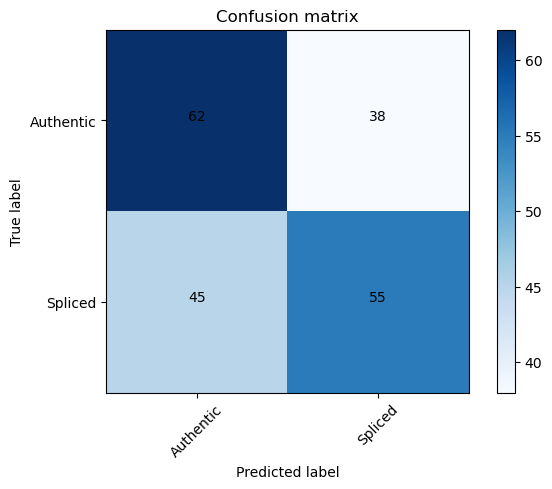

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Preprocessing for test dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder("C:/Users/91931/Desktop/Diffusion Project/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate model
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).long().squeeze()
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Plot confusion matrix
plot_confusion_matrix(cm, classes = ["Authentic", "Spliced"])

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=test_dataset.classes))